## 1. Simulate standard examples of two particles with stable algorithm

In [1]:
import numpy as np
import sys
import os

module_path = os.path.abspath(os.path.join(".."))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path + "/openmd")

from SimulatorLJ import SimulatorLJ as Simulator

/home/julian/Documents/openmd/openmd


## Define new integrator

In [2]:
def force_lj_fast(positions, constants, box_length):
    """
    :param positions:
    :type positions:
    :param constants:
    :type constants:
    :param box_length:
    :type box_length:
    :return:
    :rtype:
    """

    epsilon, sigma = constants
    num = positions.shape[0]
    force = np.zeros((num, num, 3))
    for i in range(0, num - 1):
        for j in range(i + 1, num):
            difference = positions[j, :] - positions[i, :]
            distance = np.linalg.norm(difference)
            # print("distance is", distance)
            if distance > box_length / 2:
                distance -= box_length / 2
            elif distance <= -box_length / 2:
                distance += box_length / 2
            if distance == 0:
                force[i, j] = 0
                force[j, i] = 0
                break
            # print("distance is", distance)
            lj_part = (sigma / distance) ** 6
            # print("dist, sig", distance, sigma)
            # print(sigma/distance)
            # print(0.01/3)
            # print("lj",lj_part)
            lj_part_two = lj_part**2
            factor = 24 * epsilon
            factor_two = 2 * factor
            force[i, j, :] = (factor_two * lj_part_two - factor * lj_part) * (
                difference / distance
            )
            force[j, i, :] -= force[i, j, :]
    # print(np.sum(force, axis=1))
    return np.sum(force, axis=1)

In [3]:
gamma = 0.1
dt = 0.001
coordinates = np.array([[0, 1, 0], [0, 2, 0]])
velocities = gamma * np.array([[0, 1, 0], [0, -1, 0]])
constants = [1.0, 0.5]
box_len = 6
sim = Simulator(
    mass=4,
    sim_time=40000 * dt,
    time_step=dt,
    initial_values=[coordinates, velocities],
    box_length=box_len,
    force=None,
    force_constants=constants,
    integrator=None,
    periodic=True,
)
sim.force = force_lj_fast
sim.force

positions, velocities = sim.simulate()

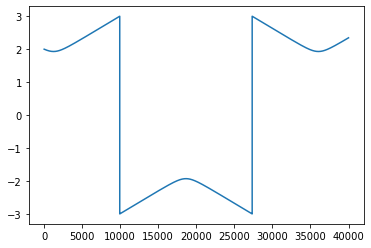

In [4]:
import matplotlib.pyplot as plt

plt.plot(positions[1, 1, :].T)

In [5]:
def energy_lj(positions, constants, box_length):
    """ """
    for i in range(0, num - 1):
        for j in range(i + 1, num):
            difference = positions[j, :] - positions[i, :]
            distance = np.linalg.norm(difference)
            if distance > box_length / 2:
                distance -= box_length / 2
            elif distance <= -box_length / 2:
                distance += box_length / 2


def energy_lj_fast(positions, constants, box_length):
    """Fast energy calculation, e.g. for MC initialization

    Args:
        positions ([type]): [description]
        constants ([type]): [description]
        box_length ([type]): [description]

    Returns:
        [type]: [description]
    """
    epsilon, sigma = constants
    separations = positions[:, None, :] - positions
    # check periodic boundary conditions
    separations[separations > box_length / 2] -= box_length
    separations[separations <= -box_length / 2] += box_length

    # calculate NxN matrix with distances |r[i] - r[j]|
    # set zero values to None for calculation of acceleration

    distances = np.linalg.norm(separations, axis=-1)
    distances[distances == 0] = None

    # calculate potential energy for Lennard Jones potential
    e_pot = (
        4
        * epsilon
        * (np.power((distances / sigma), -12) - np.power((distances / sigma), -6))
    )
    e_pot[np.isnan(e_pot)] = 0
    return np.sum(e_pot)


def kinetic_energy(V, M):
    """Calculates the kinetic energy

    Args:
        V ([type]): [description]
        M ([type]): [description]
    """

    # normed_vel =np.sum(0.5 * M*V*V,axis=0)
    # assert 1 == 2, str(len(V))
    e_kin = 0
    for i in range(len(V)):
        e_kin += 0.5 * M * np.sum(np.square(V[i, :]))
    return e_kin


def energy_gravity(positions, constants, box_length):
    """Potential energy calculation for the gravitational potential

    Args:
        positions ([type]): [description]
        constants ([type]): [description]
        box_length ([type]): [description]
    """
    G = constants[0]
    separations = positions[:, None, :] - positions

    # check periodic boundary conditions
    separations[separations > box_length / 2] -= box_length
    separations[separations <= -box_length / 2] += box_length

    # calculate NxN matrix with distances |r[i] - r[j]|
    # set zero values to None for calculation of acceleration

    distances = np.linalg.norm(separations, axis=-1)
    distances[distances == 0] = None

    # calculate potential energy for Lennard Jones potential
    e_pot = -1 * G * 1 / distances
    e_pot[np.isnan(e_pot)] = 0

    return np.sum(e_pot)

In [6]:
energy = []
e_kin = []
for i in range(positions.shape[2]):
    energy.append(
        energy_lj_fast(positions[:, :, i], constants=constants, box_length=box_len)
    )
    e_kin.append(kinetic_energy(velocities[:, :, i], 1))

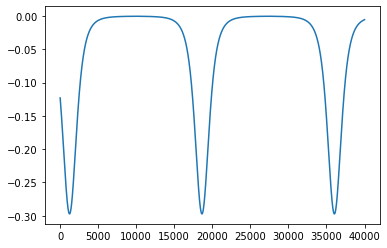

In [7]:
plt.plot(energy)

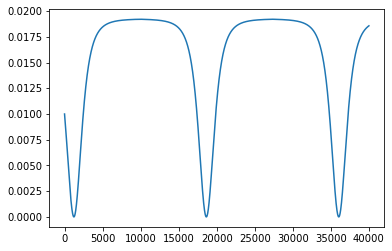

In [8]:
plt.plot(e_kin)

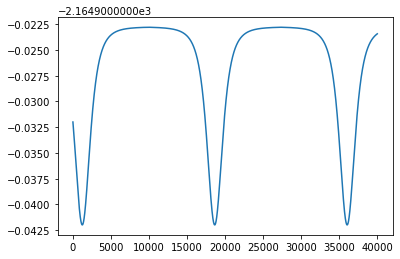

In [9]:
plt.plot(sum(energy, e_kin))

# Make Three particle experiment to see how good the integrator is performing

In [66]:
gamma = 0.1
dt = 0.0001
time = 50000
box_len = 3
coordinates = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
velocities = gamma * np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
constants = [0.2, 0.2]
sim.initial_pos = coordinates
sim.box_length = box_len
sim.initial_velocities = velocities
sim.time_step = dt
sim.sim_time = time * dt
sim.num_steps = int(sim.sim_time / sim.time_step)
sim.force_constants = constants

In [67]:
positions, velocities = sim.simulate()

In [68]:
energy = []
e_kin = []
for i in range(positions.shape[2]):
    energy.append(
        energy_lj_fast(positions[:, :, i], constants=constants, box_length=box_len)
    )
    e_kin.append(kinetic_energy(velocities[:, :, i], 1))

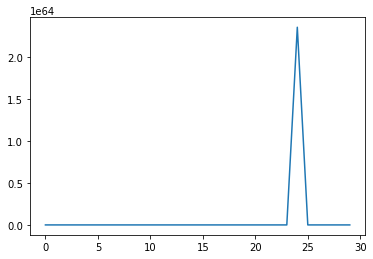

In [82]:
plt.plot(energy[48150:48180])

In [70]:
time = 10000
dt = 0.0001
coordinates = positions[:, :, -1]
velocities = velocities[:, :, -1]
sim.initial_pos = coordinates
sim.initial_velocities = velocities
sim.time_step = dt
sim.sim_time = time * dt
sim.num_steps = int(sim.sim_time / sim.time_step)
positions, velocities = sim.simulate()

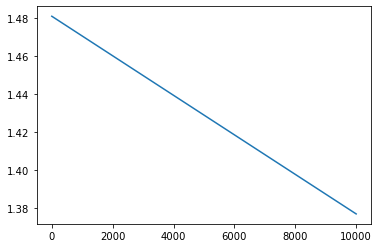

In [71]:
plt.plot(positions[0, 1, :].T)

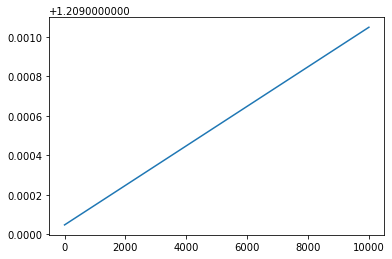

In [39]:
plt.plot(positions[2, 1, :].T)

### The simulation can handle the numerical anomaly well, and the integrator is thus suitable 